In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math 
from tensorflow import keras


### Data Cleaning

In [ ]:
dfuv = pd.read_csv("EcoTrans-AQIFinalDataset - Uv Index.csv")

frames = list(range(7,len(dfuv)+7))
dfuv["list"] = frames
dfuv["Hour"] = dfuv["list"]%24

In [ ]:
dfuv.head()

,Unnamed: 0,ozone,Temperature,uvIndex,list,Hour
0,0,255.4,29.738889,2,7,7
1,1,256.0,33.788889,4,8,8
2,2,255.3,36.077778,6,9,9
3,3,254.5,37.566667,7,10,10
4,4,254.2,39.072222,7,11,11


In [ ]:
dfuv.groupby("Hour")["uvIndex"].mean()

Hour
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.703125
7     2.046875
8     4.171875
9     5.859375
10    6.750000
11    7.039062
12    6.679688
13    5.718750
14    3.882812
15    2.000000
16    0.562500
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: uvIndex, dtype: float64

In [ ]:
dfuv = dfuv[dfuv["uvIndex"]>=1 ]
dfuv

,Unnamed: 0,ozone,Temperature,uvIndex,list,Hour
0,0,255.4,29.738889,2,7,7
1,1,256.0,33.788889,4,8,8
2,2,255.3,36.077778,6,9,9
3,3,254.5,37.566667,7,10,10
4,4,254.2,39.072222,7,11,11
...,...,...,...,...,...,...
3052,3052,253.3,38.955556,6,3059,11
3053,3053,253.4,40.027778,6,3060,12
3054,3054,253.1,40.572222,5,3061,13
3055,3055,253.1,39.644444,3,3062,14


In [ ]:
dfuv.groupby("Hour")["uvIndex"].mean()

Hour
6     1.000000
7     2.046875
8     4.171875
9     5.859375
10    6.750000
11    7.039062
12    6.679688
13    5.718750
14    3.882812
15    2.000000
16    1.000000
Name: uvIndex, dtype: float64

In [ ]:
dfuv=dfuv["uvIndex"]

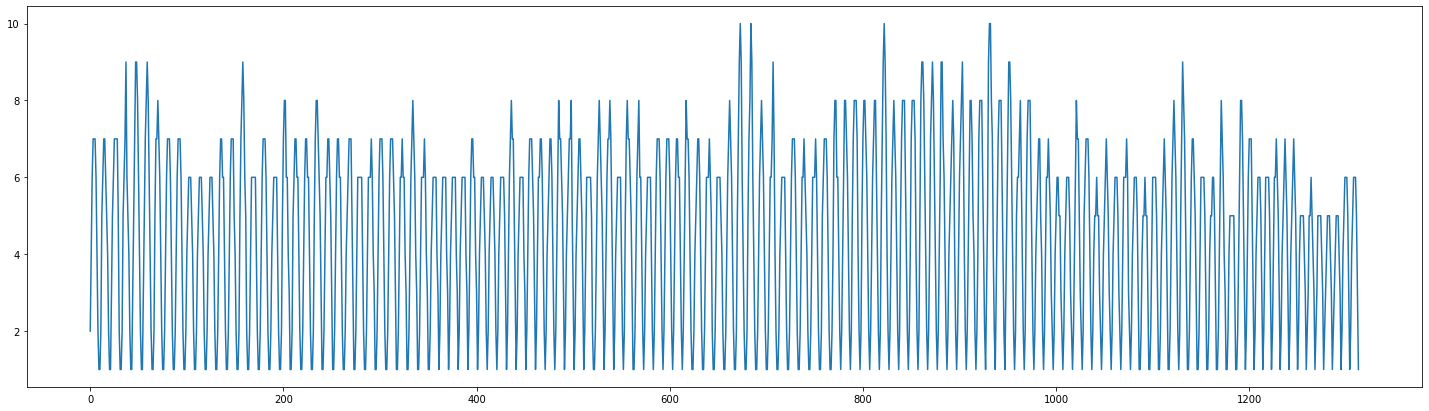

In [ ]:
plt.figure(figsize = (25,7))
plt.plot(range(len(dfuv)), dfuv)

In [ ]:
def split_counter(df,split_size):
  training = math.floor(len(df)*split_size)
  testing = math.floor(len(df) - training)

  training_set = df[:training]
  testing_set = df[training:]
  print("We have  {} for training and we have {} for testing".format(training,testing))


  return  training_set,testing_set

training_set, testing_set = split_counter(dfuv,0.9)

We have  1182 for training and we have 132 for testing


In [ ]:
a = np.array(training_set)

In [ ]:
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 72
batch_size = 128
train_set = windowed_dataset(a, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(a.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))>
(1182,)
Epoch 1/150
9/9 [==============================] - 6s 64ms/step - loss: 3.9795 - mae: 4.4793 - lr: 1.0000e-08
Epoch 2/150
9/9 [==============================] - 0s 18ms/step - loss: 3.9792 - mae: 4.4791 - lr: 1.1220e-08
Epoch 3/150
9/9 [==============================] - 0s 19ms/step - loss: 3.9788 - mae: 4.4787 - lr: 1.2589e-08
Epoch 4/150
9/9 [==============================] - 0s 17ms/step - loss: 3.9783 - mae: 4.4782 - lr: 1.4125e-08
Epoch 5/150
9/9 [==============================] - 0s 19ms/step - loss: 3.9777 - mae: 4.4776 - lr: 1.5849e-08
Epoch 6/150
9/9 [==============================] - 0s 18ms/step - loss: 3.9771 - mae: 4.4770 - lr: 1.7783e-08
Epoch 7/150
9/9 [==============================] - 0s 19ms/step - loss: 3.9763 - mae: 4.4762 - lr: 1.9953e-08
Epoch 8/150
9/9 [==============================] - 0s 20ms/step - 

(1e-08, 0.1, 0.0, 10.0)

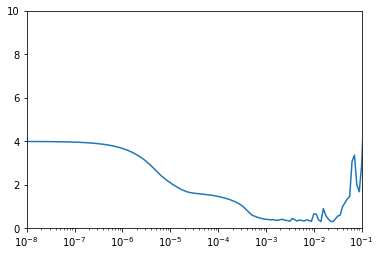

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 10])


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(a, window_size=72, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)
                                    

Epoch 1/200
12/12 [==============================] - 5s 24ms/step - loss: 2.0333 - mae: 2.4940
Epoch 2/200
12/12 [==============================] - 0s 17ms/step - loss: 1.5670 - mae: 2.0318
Epoch 3/200
12/12 [==============================] - 0s 16ms/step - loss: 1.5425 - mae: 2.0061
Epoch 4/200
12/12 [==============================] - 0s 18ms/step - loss: 1.5174 - mae: 1.9858
Epoch 5/200
12/12 [==============================] - 0s 17ms/step - loss: 1.2703 - mae: 1.7153
Epoch 6/200
12/12 [==============================] - 0s 15ms/step - loss: 1.4212 - mae: 1.8678
Epoch 7/200
12/12 [==============================] - 0s 15ms/step - loss: 0.9473 - mae: 1.3714
Epoch 8/200
12/12 [==============================] - 1s 38ms/step - loss: 0.5449 - mae: 0.9269
Epoch 9/200
12/12 [==============================] - 0s 25ms/step - loss: 0.4421 - mae: 0.8067
Epoch 10/200
12/12 [==============================] - 1s 31ms/step - loss: 0.3880 - mae: 0.7382
Epoch 11/200
12/12 [=============================

In [ ]:
datas= np.array(dfuv)
datas


array([2, 4, 6, ..., 5, 3, 1])

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, datas[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[(len(training_set) - window_size):-1, -1, 0]



In [ ]:
rnn_forecast

array([5.8402963, 5.6202183, 4.883181 , 3.2948053, 1.3967305, 0.9137288,
       1.5191114, 3.9380784, 5.5756483, 6.219461 , 7.2699394, 6.6658297,
       5.6841135, 3.6755428, 1.5407012, 1.1231273, 3.956916 , 5.857315 ,
       6.818742 , 7.020936 , 6.563631 , 5.831216 , 3.4260383, 1.3594677,
       1.3268989, 3.9509683, 5.5602055, 5.950608 , 6.3679686, 6.0104966,
       5.5714808, 3.4876738, 1.4761543, 1.364969 , 3.9199183, 5.4004045,
       6.607501 , 6.347191 , 6.0331163, 5.5703506, 3.5613208, 1.5291816,
       1.4625883, 3.9612901, 5.361661 , 6.5342546, 6.314056 , 6.4900327,
       5.5862927, 3.5693045, 1.6184049, 1.57567  , 4.0541334, 5.380926 ,
       5.74623  , 6.224064 , 6.4319706, 5.542554 , 3.5048926, 1.6041043,
       1.584382 , 4.037381 , 5.3919306, 5.759666 , 6.222959 , 6.42816  ,
       5.5447483, 3.5059607, 1.6145732, 1.5886611, 4.0406804, 5.3957705,
       5.7629356, 5.74356  , 5.5848527, 4.6872454, 3.0741143, 1.614827 ,
       1.4822056, 3.5788999, 4.875421 , 5.5842156, 

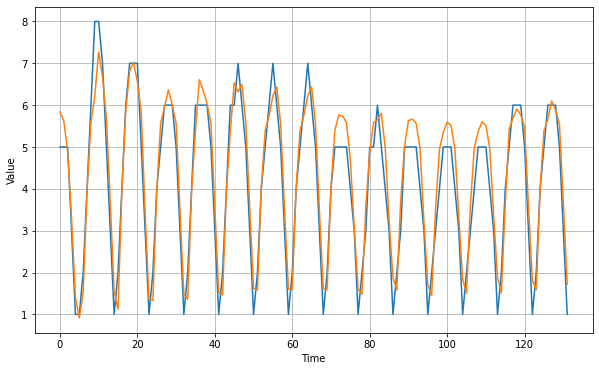

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(range(len(testing_set)), testing_set)
plot_series(range(len(testing_set)), rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(testing_set, rnn_forecast).numpy()

0.4844505

In [ ]:
#Making dataframe
frames = {"Uv":testing_set, "Uv-Forcast": rnn_forecast}
dfforecast = pd.DataFrame(frames)
dfforecast

,Uv,Uv-Forcast
2716,5,5.840296
2717,5,5.620218
2718,5,4.883181
2719,3,3.294805
2720,1,1.396731
...,...,...
3052,6,6.098453
3053,6,5.882000
3054,5,5.541586
3055,3,3.674140


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('saved_model/UvIndex2')

INFO:tensorflow:Assets written to: saved_model/UvIndex2/assets


INFO:tensorflow:Assets written to: saved_model/UvIndex2/assets


In [ ]:
UvModel = tf.keras.models.load_model('/gdrive/MyDrive/saved_model/UvIndex2')
# Check its architecture
UvModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 64)          32000     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 dense (Dense)               (None, None, 60)          7740      
                                                                 
 dropout (Dropout)           (None, None, 60)          0         
                                                                 
 dense_1 (Dense)             (None, None, 10)          610       
                                                                 
 dense_2 (Dense)             (None, None, 1)           1

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, datas[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[(len(training_set) - window_size):-1, -1, 0]


In [ ]:
rnn_forecast

array([5.8402963, 5.6202183, 4.883181 , 3.2948053, 1.3967305, 0.9137288,
       1.5191114, 3.9380784, 5.5756483, 6.219461 , 7.2699394, 6.6658297,
       5.6841135, 3.6755428, 1.5407012, 1.1231273, 3.956916 , 5.857315 ,
       6.818742 , 7.020936 , 6.563631 , 5.831216 , 3.4260383, 1.3594677,
       1.3268989, 3.9509683, 5.5602055, 5.950608 , 6.3679686, 6.0104966,
       5.5714808, 3.4876738, 1.4761543, 1.364969 , 3.9199183, 5.4004045,
       6.607501 , 6.347191 , 6.0331163, 5.5703506, 3.5613208, 1.5291816,
       1.4625883, 3.9612901, 5.361661 , 6.5342546, 6.314056 , 6.4900327,
       5.5862927, 3.5693045, 1.6184049, 1.57567  , 4.0541334, 5.380926 ,
       5.74623  , 6.224064 , 6.4319706, 5.542554 , 3.5048926, 1.6041043,
       1.584382 , 4.037381 , 5.3919306, 5.759666 , 6.222959 , 6.42816  ,
       5.5447483, 3.5059607, 1.6145732, 1.5886611, 4.0406804, 5.3957705,
       5.7629356, 5.74356  , 5.5848527, 4.6872454, 3.0741143, 1.614827 ,
       1.4822056, 3.5788999, 4.875421 , 5.5842156, 